In [ ]:
pip install matplotlib
pip install PyQt5
pip install numpy
pip install scipy

In [ ]:
import numpy as np
import glob, os, copy
%matplotlib widget
import matplotlib.pyplot as plt
plt.ion
np.set_printoptions(precision=2, suppress=True)

In [207]:
# def check_validity(current_data_value, previous_average):
def check_diff_invalidity(current_data_value, previous_average):    
    epsilon = 0.75
    return not(np.linalg.norm(current_data_value - previous_average) <= epsilon)

def check_stat_invalidity(current_data_value, previous_average):
    epsilon = 1.0
    statistical_mean = np.array([3.45, -2.4, 0.75])
    return np.linalg.norm(current_data_value - statistical_mean) <= epsilon

def check_stat_and_diff_invalidity(current_data_value, previous_average, t, latest_valid_index):

    if latest_valid_index==-1:
        previous_average = current_data_value
            
    invalid = check_diff_invalidity(current_data_value, previous_average) or check_stat_invalidity(current_data_value, previous_average)

    return invalid
    
    # return check_diff_invalidity(current_data_value, previous_average) and check_stat_invalidity(current_data_value, previous_average)
    # return check_diff_invalidity(current_data_value, previous_average) or check_stat_invalidity(current_data_value, previous_average)

def filter_outliers(data):

    filter_size = 3
    # epsilon = 0.5 * np.ones(3)
    epsilon = 0.5
    alt_data = copy.deepcopy(data)
    averages = np.zeros_like(data)
    validity = np.ones_like(data)
    latest_valid_index = -1

    # Initialize average.
    averages[0] = data[0]    

    print("Hello, about to start filtering.")    

    for k in range(1, data.shape[0]):
        
        # Check validity
        # If we think it's an outlying datapoint based on averages, rewrite the data to last valid data point, 
        # and set validity to 0. 
        # if not(check_diff_validity(alt_data[k], averages[k-1])):
        # if not(check_stat_validity(alt_data[k], averages[k-1])):   
        if check_stat_and_diff_invalidity(alt_data[k], averages[k-1], k, latest_valid_index):
            alt_data[k] = copy.deepcopy(alt_data[k-1])
            validity[k] = 0.
            # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
            averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
        else:            
            # Special case ofr us encountering the first valid data point afer a stream of invalid data points. 
            if latest_valid_index == -1:
                # Set average to current value.. 
                averages[k] = alt_data[k]
            else:
                # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
                averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)

            # Set the last valid index to current timepoint. 
            latest_valid_index = k

        # print("#######################")
        # print("Filtering timestep: ", k)
        # print(data[k], averages[k-1], np.linalg.norm(data[k] - averages[k-1]))

        # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
        # averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
    
    return averages, validity

In [ ]:
def interpolate_valid_data(valid_data, validity):

    # Reall ythis should follow the exact same pipeline as remaining dataloader stuff.. 
    # copy that shit
    return None

In [ ]:
def process_data(data):

    # Select Posiiton Data.
    processed_data = data[1:, 10:13]
    filtered_data, validity = filter_outliers(processed_data)
    # filtered_data = processed_data

    # Interpolate data - second phase 
    interpolated_data = interpolate_valid_data(filtered_data, validity)

    return filtered_data

def plot_traj(original_data, processed_data):
    # plt.close()
    plt.figure()
    plt.plot(original_data)
    plt.plot(processed_data, 'o', markersize=2)
    plt.show()

################
Processing file:  0  , named:  close_door_0.csv
Hello, about to start filtering.


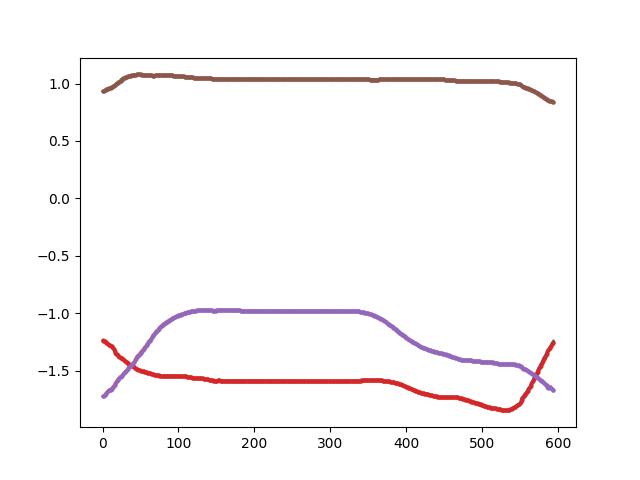

################
Processing file:  1  , named:  close_door_1.csv
Hello, about to start filtering.


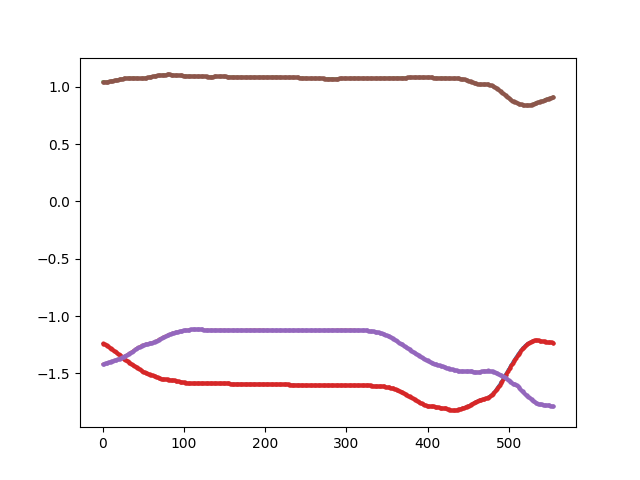

################
Processing file:  2  , named:  eggs_0.csv
Hello, about to start filtering.


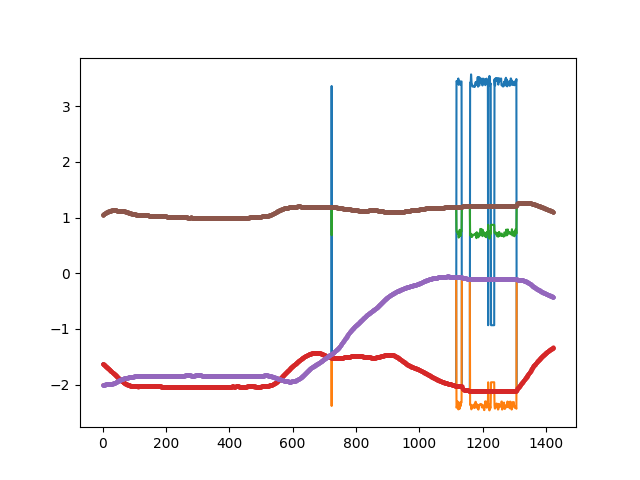

################
Processing file:  3  , named:  eggs_1.csv
Hello, about to start filtering.


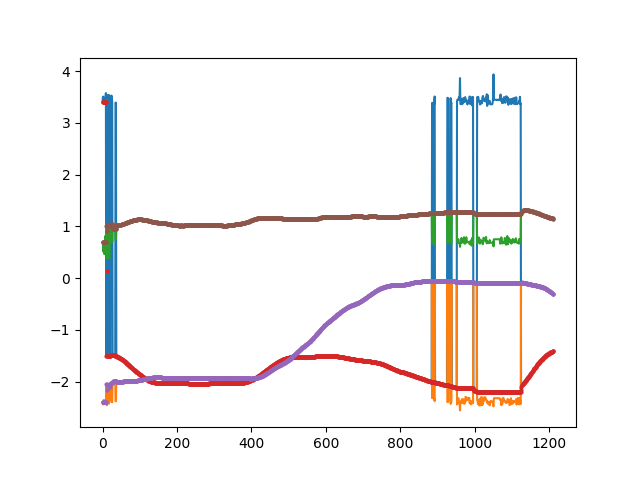

################
Processing file:  4  , named:  open_door_0.csv
Hello, about to start filtering.


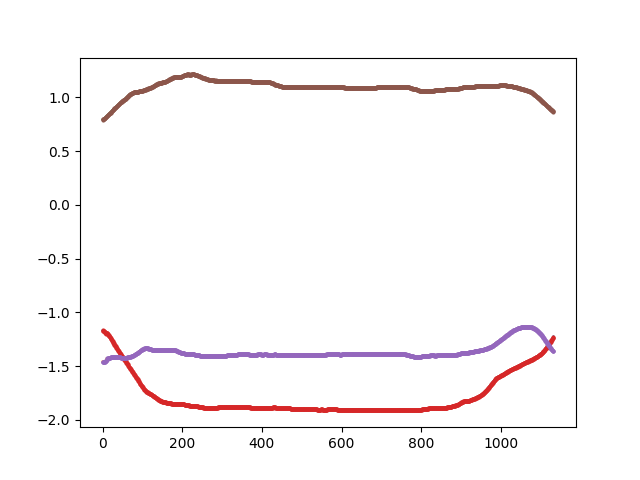

################
Processing file:  5  , named:  open_door_1.csv
Hello, about to start filtering.


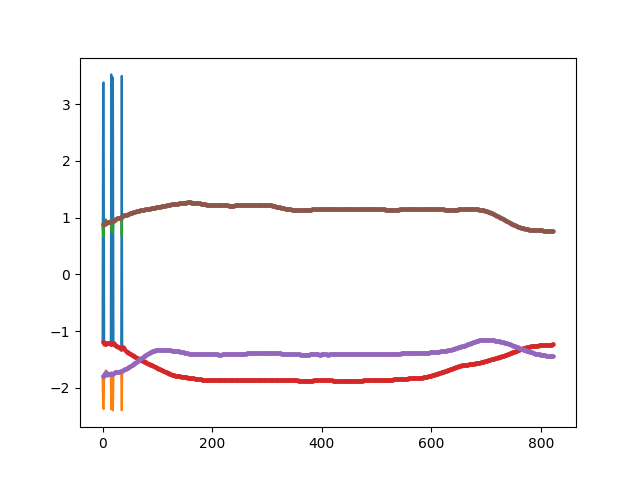

################
Processing file:  6  , named:  open_door_2.csv
Hello, about to start filtering.


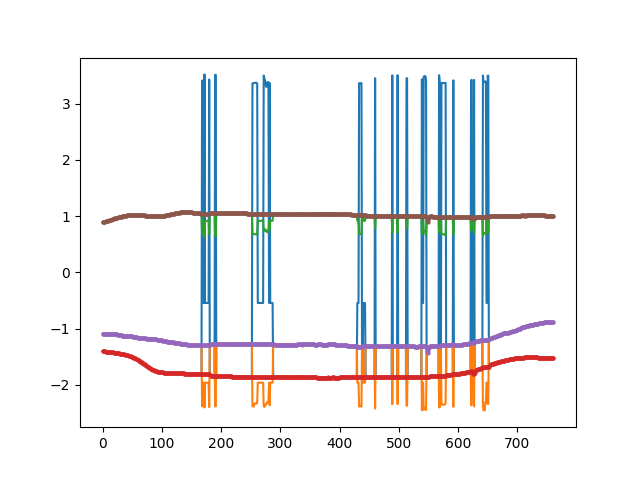

################
Processing file:  7  , named:  stock_cupboard_0.csv
Hello, about to start filtering.


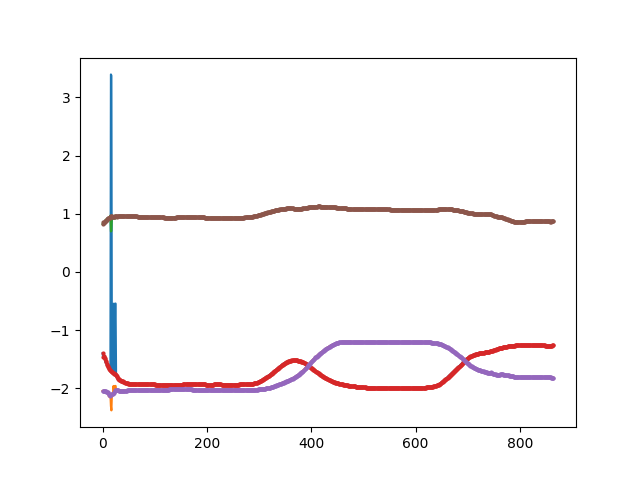

################
Processing file:  8  , named:  stock_cupboard_1.csv
Hello, about to start filtering.


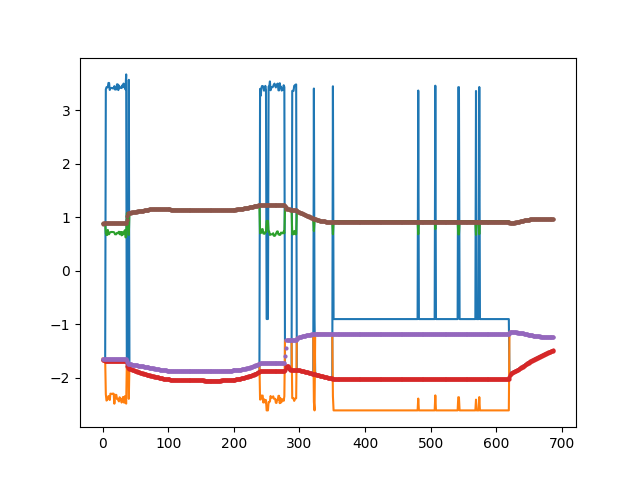

################
Processing file:  9  , named:  stock_cupboard_2.csv
Hello, about to start filtering.


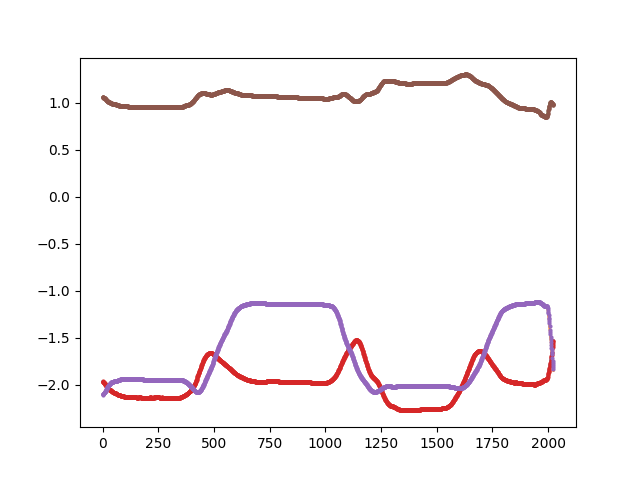

################
Processing file:  10  , named:  stock_cupboard_3.csv
Hello, about to start filtering.


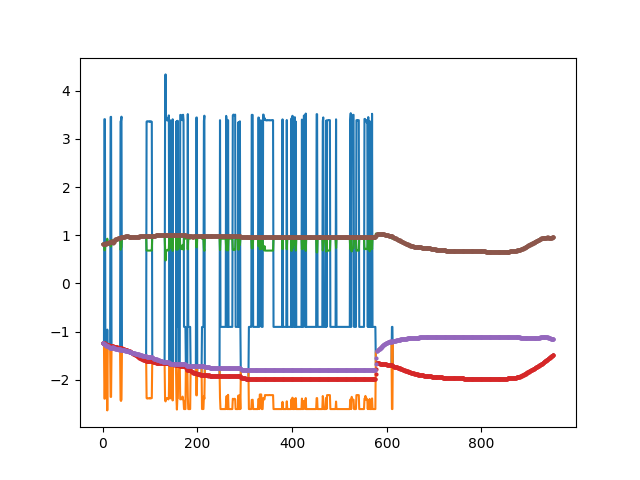

################
Processing file:  11  , named:  stock_fridge_0.csv
Hello, about to start filtering.


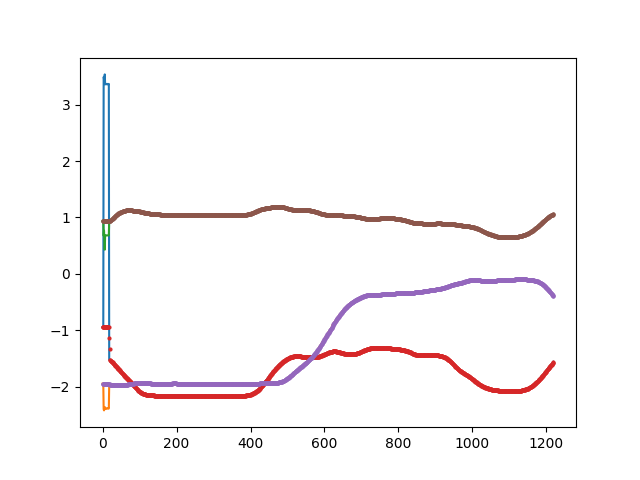

################
Processing file:  12  , named:  stock_fridge_1.csv
Hello, about to start filtering.


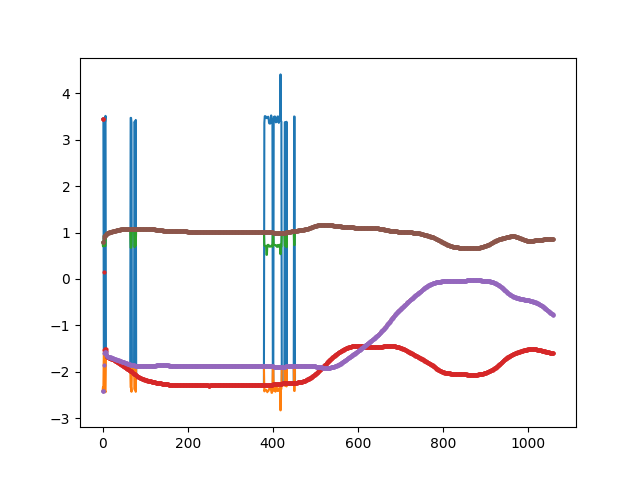

################
Processing file:  13  , named:  stock_fridge_2.csv
Hello, about to start filtering.


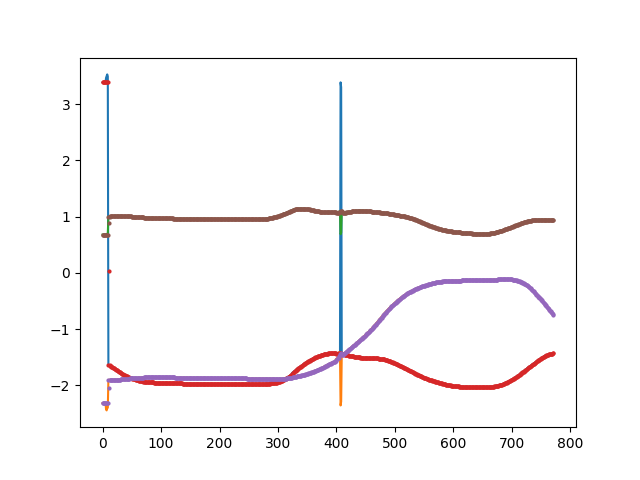

################
Processing file:  14  , named:  stock_fridge_3.csv
Hello, about to start filtering.


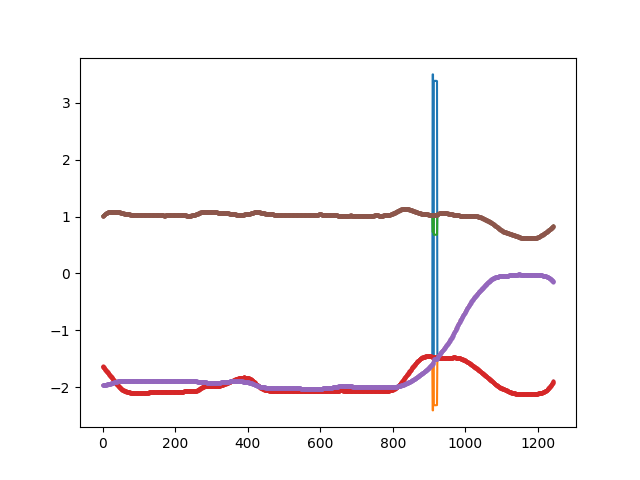

In [208]:
filelist = sorted(glob.glob("*.csv"))

for k,v in enumerate(filelist):

    # if not(v.startswith("stock_cupboard")):
    if True:
    
        print("################")
        print("Processing file: ", k, " , named: ", v)

        # Extract from file
        data = np.genfromtxt(v, delimiter=',')
        # process
        pdata = process_data(data)
        # plot
        plot_traj(data[1:, 10:13], pdata)

In [ ]:
avg, val = filter_outliers(pos)

In [ ]:
plt.figure()
plt.plot(pos[:,0], 'o')
plt.plot(avg[:,0], 'or')
plt.show()

In [198]:
# data = np.genfromtxt("eggs_1.csv", delimiter=',')
data = np.genfromtxt("stock_fridge_0.csv", delimiter=',')
pdata = process_data(data)
data[1:20, 10:13]

Hello, about to start filtering.


array([[-0.94, -1.94,  0.94],
       [-0.94, -1.94,  0.94],
       [-0.94, -1.94,  0.94],
       [ 3.49, -2.39,  0.68],
       [ 3.46, -2.42,  0.77],
       [ 3.46, -2.38,  0.59],
       [ 3.53, -2.36,  0.43],
       [ 3.36, -2.38,  0.68],
       [ 3.37, -2.39,  0.68],
       [ 3.37, -2.39,  0.68],
       [ 3.36, -2.38,  0.68],
       [ 3.36, -2.38,  0.68],
       [ 3.36, -2.38,  0.68],
       [ 3.36, -2.38,  0.68],
       [ 3.37, -2.38,  0.68],
       [ 3.35, -2.38,  0.68],
       [ 3.36, -2.38,  0.68],
       [ 3.37, -2.38,  0.68],
       [-1.52, -1.96,  0.93]])

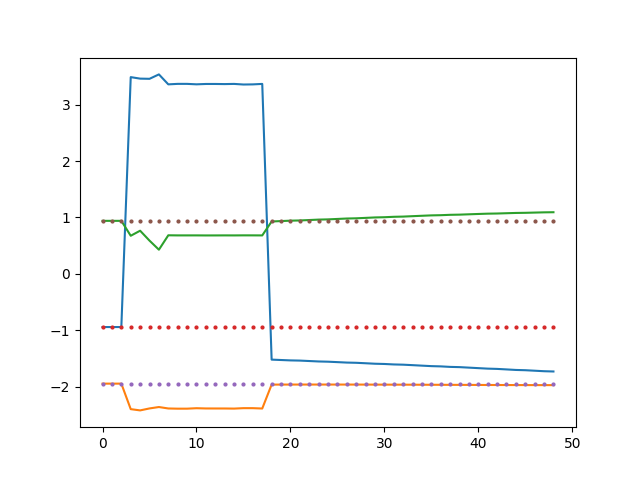

In [201]:
plot_traj(data[1:50, 10:13], pdata[:49])

In [206]:
a = data[1,10:13]
b = data[19,10:13]
a, b, np.linalg.norm(a-b)

(array([-0.94, -1.94,  0.94]),
 array([-1.52, -1.96,  0.93]),
 0.5773589416621098)